In [5]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from typing import List

#tip_testdaten_template = pd.read_csv("../Dateien/tip_testdaten_template.csv")  
orders = pd.read_parquet("orders.parquet")  
tips_public = pd.read_csv("tips_public.csv")  
order_products_denormalized = pd.read_csv("order_products_denormalized.csv")  


##### *All column names*

In [21]:
def column_names_of_all_table():
    for table in [orders, tips_public, order_products_denormalized]:
        table.drop(columns=["Unnamed: 0"], inplace=True, errors="ignore")
        print(table.columns.tolist())
column_names_of_all_table()

['order_id', 'user_id', 'order_date']
['order_id', 'tip']
['order_id', 'product_id', 'add_to_cart_order', 'product_name', 'aisle_id', 'department_id', 'department', 'aisle']


##### **Amount of Orders of User**

In [22]:
# Creating table with user and amount of orders
def create_orders_per_user_table(orders):
    orders_per_user = orders.groupby("user_id").size().reset_index(name="anzahl_bestellungen")
    return orders_per_user
orders_per_user = create_orders_per_user_table(orders)
orders_per_user 
# Plotting Table for number 1,4,5 10,20, 40, 100 how many user have at least this amount of orders:
for i in [1,4,5,10,20,40,100]:
    print(f"Anzahl der User mit {i} Bestellungen: {len(orders_per_user[orders_per_user['anzahl_bestellungen'] >= i])}".rjust(50))
# Plotting Table for number 1,2,3,4,5 10,20, 40, 100 how many user have this amount of orders:

         Anzahl der User mit 1 Bestellungen: 62032
         Anzahl der User mit 4 Bestellungen: 62032
         Anzahl der User mit 5 Bestellungen: 54334
        Anzahl der User mit 10 Bestellungen: 36154
        Anzahl der User mit 20 Bestellungen: 24276
        Anzahl der User mit 40 Bestellungen: 13693
        Anzahl der User mit 100 Bestellungen: 1289


##### *maximal amount of characters per column as strings*

In [23]:
def maximum_amount_of_characters():
    max_lens = {col: order_products_denormalized[col].astype(str).map(len).max() for col in order_products_denormalized.columns}
    print(max_lens) 
#maximum_amount_of_characters()

##### **Tip shift**

In [6]:
def create_user_tip_features(orders, tips_public, shifts=10, convert_to_int=False, keep_only_tip_columns=False, drop_na=False):
    """
    Erstellt eine Tabelle mit den letzten Trinkgeldern für jeden Nutzer.
    
    Parameters:
    - orders (pd.DataFrame): Tabelle mit Spalten ['order_id', 'user_id', 'order_date']
    - tips_public (pd.DataFrame): Tabelle mit Spalten ['order_id', 'tip']
    - convert_to_int (bool): Wenn True, werden Boolean-Tip-Werte in Integer (True -> 1, False -> 0) umgewandelt
    - keep_only_tip_columns (bool): Wenn True, werden nur Spalten mit 'tip' im Namen behalten
    - drop_na (bool): Wenn True, werden Zeilen mit NaN-Werten entfernt
    
    Returns:
    - pd.DataFrame: Verarbeitete Tabelle mit neuen tip_{i}-Spalten
    """
    # Validierung der Eingabedaten
    required_orders_cols = ['order_id', 'user_id', 'order_date']
    required_tips_cols = ['order_id', 'tip']
    if not all(col in orders.columns for col in required_orders_cols):
        raise ValueError(f"orders muss die Spalten {required_orders_cols} enthalten")
    if not all(col in tips_public.columns for col in required_tips_cols):
        raise ValueError(f"tips_public muss die Spalten {required_tips_cols} enthalten")
    
    # Schritt 1: Merge der Tabellen
    user_tip = orders.merge(tips_public, how="inner", on="order_id")
    if user_tip.empty:
        raise ValueError("Merge ergab keine übereinstimmenden order_id-Werte")
    
    # Schritt 2: Sortieren nach user_id und order_date
    user_tip['order_date'] = pd.to_datetime(user_tip['order_date'], errors='coerce')
    if user_tip['order_date'].isna().any():
        raise ValueError("Einige order_date-Werte konnten nicht in Datetime umgewandelt werden")
    user_tip = user_tip.sort_values(["user_id", "order_date"])
    
    # Schritt 3: Erstellen der tip_{i}-Spalten für die letzten 1 bis X Trinkgelder
    for i in range(1, shifts + 1):
        user_tip[f"tip_{i}"] = user_tip.groupby("user_id")["tip"].shift(i)
    
    # Schritt 4: Optional: Tip-Werte in Integer umwandeln
    if convert_to_int:
        # Konvertiere die tip-Spalte
        user_tip['tip'] = user_tip['tip'].astype(int)
        # Konvertiere die tip_{i}-Spalten und fülle NaN mit 0
        for i in range(1, shifts + 1):
            user_tip[f"tip_{i}"] = user_tip[f"tip_{i}"].fillna(0).astype(int)
    
    # Schritt 5: Optional: Nur tip-Spalten behalten
    if keep_only_tip_columns:
        tip_columns = ['user_id'] + [col for col in user_tip.columns if 'tip' in col.lower()] 
        user_tip = user_tip[tip_columns]
    
    # Schritt 6: Optional: NaN-Werte entfernen
    if drop_na:
        user_tip = user_tip.dropna()
    
    return user_tip

# Beispielaufruf (angenommen, orders und tips_public sind geladen):
user_tip = create_user_tip_features(orders, tips_public, shifts = 10, convert_to_int=True, keep_only_tip_columns=False, drop_na=False)
user_tip.head(10)

,order_id,user_id,order_date,Unnamed: 0,tip,tip_1,tip_2,tip_3,tip_4,tip_5,tip_6,tip_7,tip_8,tip_9,tip_10
0,1374495,3,2024-03-31 14:05:18,26,1,0,0,0,0,0,0,0,0,0,0
1,444309,3,2024-04-09 19:45:51,27,1,1,0,0,0,0,0,0,0,0,0
2,3002854,3,2024-04-30 16:25:20,28,1,1,1,0,0,0,0,0,0,0,0
3,2037211,3,2024-05-20 18:31:28,29,1,1,1,1,0,0,0,0,0,0,0
4,2710558,3,2024-06-01 17:52:27,30,1,1,1,1,1,0,0,0,0,0,0
5,1972919,3,2024-06-08 16:55:12,31,1,1,1,1,1,1,0,0,0,0,0
6,1839752,3,2024-06-15 15:04:06,32,0,1,1,1,1,1,1,0,0,0,0
7,3225766,3,2024-06-22 17:49:38,33,1,0,1,1,1,1,1,1,0,0,0
8,3160850,3,2024-06-29 16:49:34,34,0,1,0,1,1,1,1,1,1,0,0
9,676467,3,2024-07-16 16:27:44,35,1,0,1,0,1,1,1,1,1,1,0


In [7]:
def filter_low_order_days(orders: pd.DataFrame, min_orders: int = 300) -> pd.DataFrame:
    """
    Filtert Tage mit weniger als min_orders Bestellungen aus den orders-Daten.
    
    Parameters:
    - orders (pd.DataFrame): DataFrame mit ['order_id', 'user_id', 'order_date']
    - min_orders (int): Mindestanzahl an Bestellungen pro Tag
    
    Returns:
    - pd.DataFrame: Gefiltertes orders DataFrame
    """
    df = orders.copy()
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['day_start'] = df['order_date'].dt.to_period('D').apply(lambda r: r.start_time)
    daily_counts = df.groupby(df['order_date'].dt.date)['order_id'].count().reset_index(name='order_count')
    valid_dates = daily_counts[daily_counts['order_count'] >= min_orders]['order_date']
    valid_dates = pd.to_datetime(valid_dates)
    filtered_orders = df[df['order_date'].dt.date.isin(valid_dates.dt.date)]
    print(f"Removed {len(df) - len(filtered_orders)} orders from days with less than {min_orders} orders.")
    print(f"Remaining days: {len(valid_dates)}, Remaining orders: {len(filtered_orders)}")
    return filtered_orders

In [8]:
def filter_low_order_weeks(orders: pd.DataFrame, min_orders: int = 1200) -> pd.DataFrame:
    """
    Filtert Wochen mit weniger als min_orders Bestellungen aus den orders-Daten.
    
    Parameters:
    - orders (pd.DataFrame): DataFrame mit ['order_id', 'user_id', 'order_date']
    - min_orders (int): Mindestanzahl an Bestellungen pro Woche
    
    Returns:
    - pd.DataFrame: Gefiltertes orders DataFrame
    """
    df = orders.copy()
    df['order_date'] = pd.to_datetime(df['order_date'])
    # Erstelle Woche-Spalte basierend auf ISO-Woche
    df['week_start'] = df['order_date'].dt.to_period('W').apply(lambda r: r.start_time)
    
    # Zähle Bestellungen pro Woche
    weekly_counts = df.groupby('week_start')['order_id'].count().reset_index(name='order_count')
    
    # Finde Wochen mit mindestens min_orders
    valid_weeks = weekly_counts[weekly_counts['order_count'] >= min_orders]['week_start']
    valid_weeks = pd.to_datetime(valid_weeks)
    
    # Filtere Bestellungen aus gültigen Wochen
    filtered_orders = df[df['week_start'].isin(valid_weeks)]
    
    print(f"Removed {len(df) - len(filtered_orders)} orders from weeks with less than {min_orders} orders.")
    print(f"Remaining weeks: {len(valid_weeks)}, Remaining orders: {len(filtered_orders)}")
    
    return filtered_orders

In [9]:
def filter_low_order_months(orders: pd.DataFrame, min_orders: int = 3500) -> pd.DataFrame:
    """
    Filtert Monate mit weniger als min_orders Bestellungen aus den orders-Daten.
    
    Parameters:
    - orders (pd.DataFrame): DataFrame mit ['order_id', 'user_id', 'order_date']
    - min_orders (int): Mindestanzahl an Bestellungen pro Monat
    
    Returns:
    - pd.DataFrame: Gefiltertes orders DataFrame
    """
    df = orders.copy()
    df['order_date'] = pd.to_datetime(df['order_date'])
    # Erstelle Monat-Spalte basierend auf Jahr und Monat
    df['month_start'] = df['order_date'].dt.to_period('M').apply(lambda r: r.start_time)
    
    # Zähle Bestellungen pro Monat
    monthly_counts = df.groupby('month_start')['order_id'].count().reset_index(name='order_count')
    
    # Finde Monate mit mindestens min_orders
    valid_months = monthly_counts[monthly_counts['order_count'] >= min_orders]['month_start']
    valid_months = pd.to_datetime(valid_months)
    
    # Filtere Bestellungen aus gültigen Monaten
    filtered_orders = df[df['month_start'].isin(valid_months)]
    
    print(f"Removed {len(df) - len(filtered_orders)} orders from months with less than {min_orders} orders.")
    print(f"Remaining months: {len(valid_months)}, Remaining orders: {len(filtered_orders)}")
    
    return filtered_orders

##### **Trend**

Trend: sqrt
Removed 1422 orders from weeks with less than 1200 orders.
Remaining weeks: 64, Remaining orders: 1462210


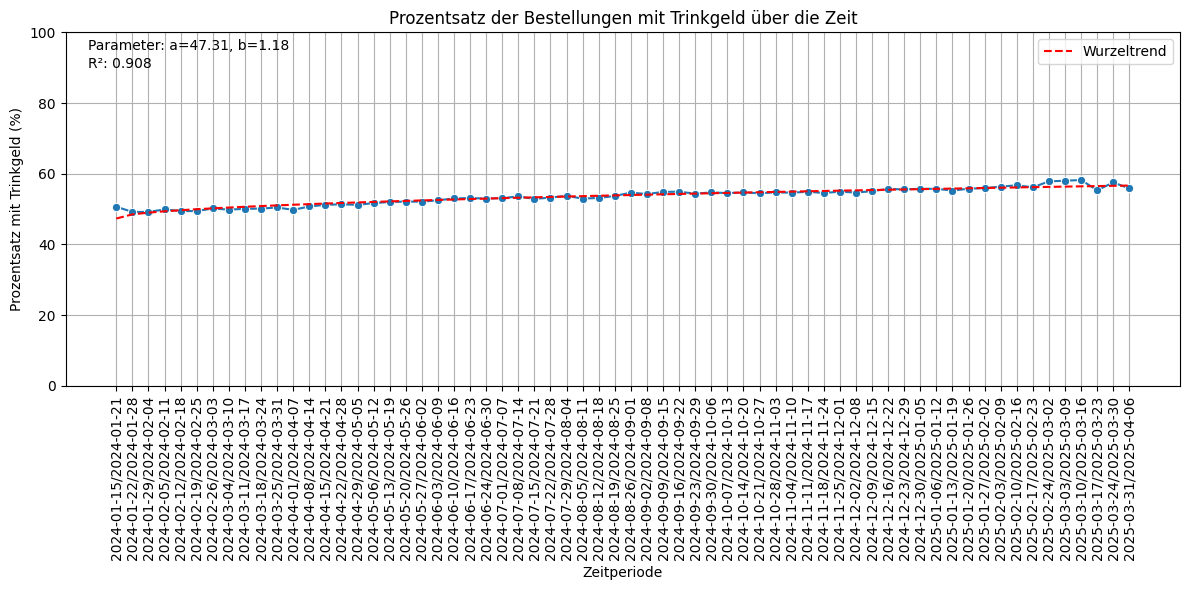

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit

def plot_tip_time_series(orders, tips_public, period='M', trend_type='linear'):
    """
    Erstellt eine Zeitreihe des Prozentsatzes der Bestellungen mit Trinkgeld und visualisiert sie als Liniendiagramm
    mit einer angepassten Trendkurve und R²-Wert.
    
    Parameters:
    - orders (pd.DataFrame): Tabelle mit Spalten ['order_id', 'user_id', 'order_date']
    - tips_public (pd.DataFrame): Tabelle mit Spalten ['order_id', 'tip']
    - period (str): Aggregationsperiode ('Y', 'Q', 'M', 'W', 'D', 'H' oder z. B. 'W-MON', 'Q-MAR')
    - trend_type (str): Art der Trendkurve ('linear', 'exponential', 'quadratic', 'cubic', 'log', 'sqrt', 'power', 'sigmoid', 'sinus')
    
    Returns:
    - None: Speichert das Diagramm als 'tip_time_series.png'
    """
    # Schritt 1: user_tip-Tabelle erstellen
    user_tip = create_user_tip_features(orders, tips_public, convert_to_int=False, keep_only_tip_columns=False, drop_na=False)
    
    # Schritt 2: Aggregation nach Zeitperiode
    user_tip['order_date'] = pd.to_datetime(user_tip['order_date'])  # Sicherstellen, dass order_date Datetime ist
    try:
        if period in ['Y', 'A', 'Q', 'M', 'W', 'D', 'H'] or period.startswith(('Y-', 'A-', 'Q-', 'W-')):
            user_tip['time_period'] = user_tip['order_date'].dt.to_period(period)
        else:
            raise ValueError("Ungültige Periode. Erlaubte Werte: 'Y', 'A', 'Q', 'M', 'W', 'D', 'H' oder z. B. 'W-MON', 'Q-MAR'")
    except ValueError as e:
        raise ValueError(f"Fehler bei der Umwandlung in Zeitperiode: {e}")
    
    # Berechne den Prozentsatz der Bestellungen mit Trinkgeld
    tip_percentage = user_tip.groupby('time_period')['tip'].mean().reset_index(name='tip_percentage')
    tip_percentage['tip_percentage'] = tip_percentage['tip_percentage'] * 100  # In Prozent umwandeln
    tip_percentage['time_period'] = tip_percentage['time_period'].astype(str)  # Für die Darstellung
    
    # Schritt 3: Liniendiagramm erstellen
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=tip_percentage, x='time_period', y='tip_percentage', marker='o')
    
    # Trendkurve berechnen
    # Zeitindex (beginnt bei 1 für logarithmische Funktion, um ln(0) zu vermeiden)
    x = np.arange(len(tip_percentage)) + 1  # Für log, power, sigmoid
    x_alt = np.arange(len(tip_percentage))  # Für Funktionen, die x=0 erlauben
    y = tip_percentage['tip_percentage'].values
    
    # Definition der Trendfunktionen
    if trend_type == 'linear':
        def trend_func(x, a, b):
            return a + b * x
        label = 'Linearer Trend'
        x_data = x_alt
    elif trend_type == 'exponential':
        def trend_func(x, a, b):
            return a * np.exp(b * x)
        label = 'Exponentieller Trend'
        x_data = x_alt
    elif trend_type == 'quadratic':
        def trend_func(x, a, b, c):
            return a + b * x + c * x**2
        label = 'Quadratischer Trend'
        x_data = x_alt
    elif trend_type == 'cubic':
        def trend_func(x, a, b, c, d):
            return a + b * x + c * x**2 + d * x**3
        label = 'Kubischer Trend'
        x_data = x_alt
    elif trend_type == 'log':
        def trend_func(x, a, b):
            return a + b * np.log(x)
        label = 'Logarithmischer Trend'
        x_data = x
    elif trend_type == 'sqrt':
        def trend_func(x, a, b):
            return a + b * np.sqrt(x)
        label = 'Wurzeltrend'
        x_data = x_alt
    elif trend_type == 'power':
        def trend_func(x, a, b):
            return a * x**b
        label = 'Potenztrend'
        x_data = x
    elif trend_type == 'sigmoid':
        def trend_func(x, L, k, x0):
            return L / (1 + np.exp(-k * (-x - x0)))   # eigentlich L/(1+e^(-k*(x-x0))) aber x ist hier experimentell negativ 
        label = 'Sigmoid-Trend'
        x_data = x
    elif trend_type == 'sinus':
        def trend_func(x, a, b, c, d):
            return a + b * np.sin(c * x + d)
        label = 'Sinus-Trend'
        x_data = x_alt
    else:
        raise ValueError("trend_type muss einer von 'linear', 'exponential', 'quadratic', 'cubic', 'log', 'sqrt', 'power', 'sigmoid', 'sinus' sein")
    
    # Kurvenanpassung
    try:
        popt, _ = curve_fit(trend_func, x_data, y, maxfev=10000)
    except RuntimeError as e:
        print(f"Warnung: Kurvenanpassung fehlgeschlagen für {trend_type}: {e}")
        popt = [0] * trend_func.__code__.co_argcount  # Fallback: Null-Parameter
    
    # Trendkurve zeichnen
    y_pred = trend_func(x_data, *popt)
    plt.plot(tip_percentage['time_period'], y_pred, color='red', linestyle='--', label=label)
    
    # R²-Wert berechnen
    ss_tot = np.sum((y - np.mean(y))**2)  # Total Sum of Squares
    ss_res = np.sum((y - y_pred)**2)  # Residual Sum of Squares
    r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
    
    # Parameter und R² anzeigen
    param_str = ', '.join([f'{chr(97+i)}={p:.2f}' for i, p in enumerate(popt)])  # a=..., b=..., etc.
    plt.text(0.02, 0.98, f'Parameter: {param_str}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    plt.text(0.02, 0.93, f'R²: {r_squared:.3f}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    
    plt.title('Prozentsatz der Bestellungen mit Trinkgeld über die Zeit')
    plt.xlabel('Zeitperiode')
    plt.ylabel('Prozentsatz mit Trinkgeld (%)')
    plt.ylim(0, 100)  # Y-Achse auf 0-100 setzen
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.legend()  # Legende hinzufügen
    plt.tight_layout()
    #plt.savefig('tip_time_series.png')  # Speichern statt plt.show()
    plt.show()
    plt.close()

all_functions: List[str] = ['linear', 'exponential', 'quadratic', 'cubic', 'log', 'sqrt', 'power', 'sigmoid', 'sinus']
all_functions: List[str] = ["sqrt"]

for i in all_functions:
    print(f"Trend: {i}")
    plot_tip_time_series(filter_low_order_weeks(orders), tips_public, period='W', trend_type=i)
#plot_tip_time_series(orders, tips_public, period='M', trend_type='cubic')


##### Trend 2.1

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit
from typing import Tuple

# Assuming create_user_tip_features is available from your original code
# and orders, tips_public are loaded DataFrames

def aggregate_tip_probability_by_day(user_tip: pd.DataFrame, period: str = 'D') -> pd.DataFrame:
    """
    Aggregates tip probability by time period (e.g., daily).
    
    Parameters:
    - user_tip (pd.DataFrame): DataFrame with ['order_date', 'tip']
    - period (str): Aggregation period ('D' for daily, 'W', 'M', etc.)
    
    Returns:
    - pd.DataFrame: DataFrame with ['time_period', 'tip_percentage']
    """
    user_tip['order_date'] = pd.to_datetime(user_tip['order_date'])
    try:
        user_tip['time_period'] = user_tip['order_date'].dt.to_period(period)
    except ValueError as e:
        raise ValueError(f"Fehler bei der Umwandlung in Zeitperiode: {e}")
    
    tip_percentage = user_tip.groupby('time_period')['tip'].mean().reset_index()
    tip_percentage = tip_percentage.rename(columns={'tip': 'tip_percentage'})
    tip_percentage['tip_percentage'] = tip_percentage['tip_percentage'] * 100  # Convert to percentage
    tip_percentage['time_period'] = tip_percentage['time_period'].astype(str)
    return tip_percentage

In [27]:

def calculate_weekend_weekday_diff(user_tip: pd.DataFrame) -> Tuple[float, float, float]:
    """
    Calculates tip probability for weekends and weekdays and their difference.
    
    Parameters:
    - user_tip (pd.DataFrame): DataFrame with ['order_date', 'tip']
    
    Returns:
    - Tuple[float, float, float]: (weekday_tip_rate, weekend_tip_rate, tip_diff) in percentages
    """
    user_tip['is_weekend'] = user_tip['order_date'].dt.dayofweek.isin([5, 6])  # Sat=5, Sun=6
    tip_rates = user_tip.groupby('is_weekend')['tip'].mean()
    weekday_tip_rate = tip_rates.get(False, 0) * 100
    weekend_tip_rate = tip_rates.get(True, 0) * 100
    tip_diff = weekend_tip_rate - weekday_tip_rate
    return weekday_tip_rate, weekend_tip_rate, tip_diff


In [ ]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit
from typing import Tuple

# orders: ['order_id', 'user_id', 'order_date']
# tips_public: ['order_id', 'tip']

def create_daily_tip_probability(orders: pd.DataFrame, tips_public: pd.DataFrame, period: str = 'D') -> pd.DataFrame:
    df = orders[['order_id', 'order_date']].merge(tips_public[['order_id', 'tip']], on='order_id', how='inner')
    df['order_date'] = pd.to_datetime(df['order_date'])
    try:
        df['time_period'] = df['order_date'].dt.to_period(period)
    except ValueError as e:
        raise ValueError(f"Fehler bei der Umwandlung in Zeitperiode: {e}")
    tip_percentage = df.groupby('time_period')['tip'].mean().reset_index()
    tip_percentage = tip_percentage.rename(columns={'tip': 'tip_percentage'})
    tip_percentage['tip_percentage'] = tip_percentage['tip_percentage'] * 100
    tip_percentage['time_period'] = tip_percentage['time_period'].apply(lambda x: x.to_timestamp().strftime('%Y-%m-%d'))
    return tip_percentage

def calculate_weekend_weekday_diff(orders: pd.DataFrame, tips_public: pd.DataFrame) -> Tuple[float, float, float]:
    df = orders[['order_id', 'order_date']].merge(tips_public[['order_id', 'tip']], on='order_id', how='inner')
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['is_weekend'] = df['order_date'].dt.dayofweek.isin([5, 6])
    tip_rates = df.groupby('is_weekend')['tip'].mean()
    weekday_tip_rate = tip_rates.get(False, 0) * 100
    weekend_tip_rate = tip_rates.get(True, 0) * 100
    tip_diff = weekend_tip_rate - weekday_tip_rate
    return weekday_tip_rate, weekend_tip_rate, tip_diff

def plot_weekend_weekday_diff(weekday_tip_rate: float, weekend_tip_rate: float, tip_diff: float) -> None:
    plt.figure(figsize=(8, 6))
    sns.barplot(x=['Wochentage', 'Wochenende'], y=[weekday_tip_rate, weekend_tip_rate])
    plt.title('Trinkgeldwahrscheinlichkeit: Wochentage vs. Wochenende')
    plt.ylabel('Prozentsatz mit Trinkgeld (%)')
    plt.text(0.5, max(weekday_tip_rate, weekend_tip_rate) * 0.9, 
             f'Differenz: {tip_diff:.2f}%', ha='center', fontsize=10)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

def create_adjusted_daily_tip_probability(orders: pd.DataFrame, tips_public: pd.DataFrame, period: str = 'D') -> pd.DataFrame:
    df = orders[['order_id', 'order_date']].merge(tips_public[['order_id', 'tip']], on='order_id', how='inner')
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['is_weekend'] = df['order_date'].dt.dayofweek.isin([5, 6])
    df['week'] = df['order_date'].dt.to_period('W')
    tip_rates_by_week = df.groupby(['week', 'is_weekend'])['tip'].mean().unstack()
    tip_rates_by_week['tip_diff'] = (tip_rates_by_week.get(True, 0) - tip_rates_by_week.get(False, 0)) * 100
    df = df.merge(tip_rates_by_week['tip_diff'].reset_index(), on='week', how='left')
    df['adjusted_tip'] = df['tip'].where(
        ~df['is_weekend'],
        df['tip'] - df['tip_diff'] / 100
    )
    df['adjusted_tip'] = df['adjusted_tip'].clip(0, 1)
    try:
        df['time_period'] = df['order_date'].dt.to_period(period)
    except ValueError as e:
        raise ValueError(f"Fehler bei der Umwandlung in Zeitperiode: {e}")
    tip_percentage = df.groupby('time_period')['adjusted_tip'].mean().reset_index()
    tip_percentage = tip_percentage.rename(columns={'adjusted_tip': 'tip_percentage'})
    tip_percentage['tip_percentage'] = tip_percentage['tip_percentage'] * 100
    tip_percentage['time_period'] = tip_percentage['time_period'].apply(lambda x: x.to_timestamp().strftime('%Y-%m-%d'))
    return tip_percentage

def plot_tip_time_series(tip_percentage: pd.DataFrame, title: str, adjusted: bool = False) -> None:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=tip_percentage, x='time_period', y='tip_percentage', marker='o')
    plt.title(title + (' (Wochenendanpassung)' if adjusted else ''))
    plt.xlabel('Zeitperiode')
    plt.ylabel('Prozentsatz mit Trinkgeld (%)')
    plt.ylim(0, 100)
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def fit_trend_curve(tip_percentage: pd.DataFrame, trend_type: str = 'sqrt') -> Tuple[np.ndarray, float, list]:
    x = np.arange(len(tip_percentage)) + 1
    x_alt = np.arange(len(tip_percentage))
    y = tip_percentage['tip_percentage'].values
    if trend_type == 'sqrt':
        def trend_func(x, a, b):
            return a + b * np.sqrt(x)
        x_data = x_alt
    else:
        raise ValueError("Nur 'sqrt' wird derzeit unterstützt. Erweitern Sie für andere Typen.")
    try:
        popt, _ = curve_fit(trend_func, x_data, y, maxfev=10000)
    except RuntimeError as e:
        print(f"Warnung: Kurvenanpassung fehlgeschlagen für {trend_type}: {e}")
        popt = [0, 0]
    y_pred = trend_func(x_data, *popt)
    ss_tot = np.sum((y - np.mean(y))**2)
    ss_res = np.sum((y - y_pred)**2)
    r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
    return y_pred, r_squared, popt

def plot_trend_curve(tip_percentage: pd.DataFrame, y_pred: np.ndarray, r_squared: float, popt: list, trend_type: str = 'sqrt') -> None:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=tip_percentage, x='time_period', y='tip_percentage', marker='o', label='Daten')
    plt.plot(tip_percentage['time_period'], y_pred, color='red', linestyle='--', label=f'{trend_type.capitalize()}-Trend')
    param_str = ', '.join([f'{chr(97+i)}={p:.2f}' for i, p in enumerate(popt)])
    plt.text(0.02, 0.98, f'Parameter: {param_str}', transform=plt.gca().transAxes, fontsize=10, va='top')
    plt.text(0.02, 0.93, f'R²: {r_squared:.3f}', transform=plt.gca().transAxes, fontsize=10, va='top')
    plt.title('Trinkgeldwahrscheinlichkeit mit Trend (Wochenendanpassung)')
    plt.xlabel('Zeitperiode')
    plt.ylabel('Prozentsatz mit Trinkgeld (%)')
    plt.ylim(0, 100)
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_daily_order_counts(orders: pd.DataFrame) -> None:
    """
    Berechnet und visualisiert die Anzahl der Bestellungen pro Tag.
    
    Parameters:
    - orders (pd.DataFrame): DataFrame mit ['order_id', 'user_id', 'order_date']
    """
    df = orders[['order_date']].copy()
    df['order_date'] = pd.to_datetime(df['order_date'])
    daily_counts = df.groupby(df['order_date'].dt.date)['order_date'].count().reset_index(name='order_count')
    daily_counts['order_date'] = pd.to_datetime(daily_counts['order_date']).dt.strftime('%Y-%m-%d')
    daily_counts['is_weekend'] = pd.to_datetime(daily_counts['order_date']).dt.dayofweek.isin([5, 6])
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=daily_counts, x='order_date', y='order_count', marker='o', hue='is_weekend', palette={False: 'blue', True: 'orange'})
    plt.title('Anzahl der Bestellungen pro Tag')
    plt.xlabel('Datum')
    plt.ylabel('Anzahl der Bestellungen')
    plt.xticks(rotation=90)
    plt.grid(True)
    # Entferne manuelle labels, lass Seaborn die Legende automatisch generieren
    plt.legend(title='Wochenende')
    plt.tight_layout()
    plt.show()

#Anzahl Bestellungen pro Tag
orders[['order_date']].groupby(orders['order_date'].dt.date)['order_date'].count().reset_index(name='order_count') 

,order_date,order_count
0,2024-01-17,74
1,2024-01-18,215
2,2024-01-19,319
3,2024-01-20,514
4,2024-01-21,645
...,...,...
456,2025-04-17,42
457,2025-04-18,34
458,2025-04-19,31
459,2025-04-20,5


##### Trend 2.2

In [29]:
def create_adjusted_daily_tip_probability_monthly(orders: pd.DataFrame, tips_public: pd.DataFrame, period: str = 'D') -> pd.DataFrame:
    """
    Creates a DataFrame with daily tip probability, adjusted for weekend-weekday difference per month.
    
    Parameters:
    - orders (pd.DataFrame): DataFrame with ['order_id', 'user_id', 'order_date']
    - tips_public (pd.DataFrame): DataFrame with ['order_id', 'tip']
    - period (str): Aggregation period for output ('D' for daily, 'W', 'M', etc.)
    
    Returns:
    - pd.DataFrame: DataFrame with ['time_period', 'tip_percentage']
    """
    df = orders[['order_id', 'order_date']].merge(tips_public[['order_id', 'tip']], on='order_id', how='inner')
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['is_weekend'] = df['order_date'].dt.dayofweek.isin([5, 6])
    df['month'] = df['order_date'].dt.to_period('M')  # Monatliche Granularität
    tip_rates_by_month = df.groupby(['month', 'is_weekend'])['tip'].mean().unstack()
    tip_rates_by_month['tip_diff'] = (tip_rates_by_month.get(True, 0) - tip_rates_by_month.get(False, 0)) * 100
    df = df.merge(tip_rates_by_month['tip_diff'].reset_index(), on='month', how='left')
    df['adjusted_tip'] = df['tip'].where(
        ~df['is_weekend'],
        df['tip'] - df['tip_diff'] / 100
    )
    df['adjusted_tip'] = df['adjusted_tip'].clip(0, 1)
    try:
        df['time_period'] = df['order_date'].dt.to_period(period)
    except ValueError as e:
        raise ValueError(f"Fehler bei der Umwandlung in Zeitperiode: {e}")
    tip_percentage = df.groupby('time_period')['adjusted_tip'].mean().reset_index()
    tip_percentage = tip_percentage.rename(columns={'adjusted_tip': 'tip_percentage'})
    tip_percentage['tip_percentage'] = tip_percentage['tip_percentage'] * 100
    tip_percentage['time_period'] = tip_percentage['time_period'].apply(lambda x: x.to_timestamp().strftime('%Y-%m-%d'))
    return tip_percentage

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose

def decompose_tip_time_series(tip_percentage: pd.DataFrame, period: int = 7) -> None:
    """
    Führt eine saisonale Dekomposition der Trinkgeldzeitreihe durch und visualisiert die Komponenten.
    
    Parameters:
    - tip_percentage (pd.DataFrame): DataFrame mit ['time_period', 'tip_percentage']
    - period (int): Periodizität der saisonalen Komponente (z. B. 7 für wöchentliche Zyklen)
    """
    # Stelle sicher, dass time_period datetime ist
    df = tip_percentage.copy()
    df['time_period'] = pd.to_datetime(df['time_period'])
    df = df.set_index('time_period')
    
    # Führe saisonale Dekomposition durch
    decomposition = seasonal_decompose(df['tip_percentage'], model='additive', period=period)
    
    # Plot der Komponenten
    plt.figure(figsize=(12, 10))
    
    plt.subplot(411)
    plt.plot(decomposition.observed, label='Original')
    plt.title('Originale Zeitreihe')
    plt.xticks(rotation=90)
    plt.grid(True)
    
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend', color='red')
    plt.title('Trend')
    plt.xticks(rotation=90)
    plt.grid(True)
    
    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Saisonal', color='green')
    plt.title('Saisonale Komponente')
    plt.xticks(rotation=90)
    plt.grid(True)
    
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Rest', color='purple')
    plt.title('Rest (Rauschen)')
    plt.xticks(rotation=90)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

##### Neue Features

In [32]:
def new_feture_tabel_for_users():
    d = pd.DataFrame(orders.groupby("user_id")["order_id"].count()) \
        .merge(orders[["user_id"]], how="inner", on="user_id") \
        .drop_duplicates()[["user_id", "order_id"]] \
        .sort_values("user_id") \
        .set_index("user_id") \
        .rename(columns={"order_id": "n_orders"}) \
        .join(user_tip[["user_id", "tip"]].groupby("user_id")["tip"].sum().reset_index().set_index("user_id").rename(columns={"tip": "n_tips"})) \
        .join(user_tip[["user_id", "tip"]].groupby("user_id")["tip"].mean().reset_index().set_index("user_id").rename(columns={"tip": "mean_tip"})) \
        .join(user_tip[["user_id", "tip"]].groupby("user_id")["tip"].std().reset_index().set_index("user_id").rename(columns={"tip": "std_tip"})) \
        .join(user_tip[["user_id", "tip"]].groupby("user_id")["tip"].min().reset_index().set_index("user_id").rename(columns={"tip": "min_tip"})) \
        .join(user_tip[["user_id", "tip"]].groupby("user_id")["tip"].max().reset_index().set_index("user_id").rename(columns={"tip": "max_tip"}))   # does at least one tip exist (max=True)  # ↑ does a user tip only (min=True) 

    return d.reset_index()

    d.head(1)
# only prints it out, not save it to a variable
new_feture_tabel_for_users()

,user_id,n_orders,n_tips,mean_tip,std_tip,min_tip,max_tip
0,3,13,10,0.833333,0.389249,0,1
1,5,5,2,0.500000,0.577350,0,1
2,6,4,0,0.000000,0.000000,0,0
3,13,13,8,0.666667,0.492366,0,1
4,15,23,9,0.409091,0.503236,0,1
...,...,...,...,...,...,...,...
62027,206187,35,32,0.941176,0.238833,0,1
62028,206189,7,1,0.166667,0.408248,0,1
62029,206204,5,1,0.250000,0.500000,0,1
62030,206206,68,15,0.223881,0.419989,0,1


##### **Correlation tip - 2 and tip - 1 and tip**

In [51]:
def tip_from_tip1_and_tip2():
    user_tip_2 = user_tip[["user_id", "tip", "tip_1", "tip_2"]].dropna().astype({"tip": "int32", "tip_1": "int32", "tip_2": "int32"}).copy()

    summ = user_tip_2.query("tip_1 == 0 and tip_2 == 0").tip.sum()
    amount = user_tip_2.query("tip_1 == 0 and tip_2 == 0").tip.count()
    print(f"The sum of tips is {summ} and the amount of tips is {amount}; the percentage is {summ/amount:.2%}.")

    summ = user_tip_2.query("tip_1 == 0 and tip_2 == 1").tip.sum()
    amount = user_tip_2.query("tip_1 == 0 and tip_2 == 1").tip.count()
    print(f"The sum of tips is {summ} and the amount of tips is {amount}; the percentage is {summ/amount:.2%}.")

    summ = user_tip_2.query("tip_1 == 1 and tip_2 == 0").tip.sum()
    amount = user_tip_2.query("tip_1 == 1 and tip_2 == 0").tip.count()
    print(f"The sum of tips is {summ} and the amount of tips is {amount}; the percentage is {summ/amount:.2%}.")

    summ = user_tip_2.query("tip_1 == 1 and tip_2 == 1").tip.sum()
    amount = user_tip_2.query("tip_1 == 1 and tip_2 == 1").tip.count()
    print(f"The sum of tips is {summ} and the amount of tips is {amount}; the percentage is {summ/amount:.2%}.")
tip_from_tip1_and_tip2()

The sum of tips is 132967 and the amount of tips is 521591; the percentage is 25.49%.
The sum of tips is 76225 and the amount of tips is 170871; the percentage is 44.61%.
The sum of tips is 119231 and the amount of tips is 201208; the percentage is 59.26%.
The sum of tips is 411103 and the amount of tips is 507930; the percentage is 80.94%.


Das selbe Ergebnis für tip = 1 ist, wenn man nur tip_1 gegeben ist

##### Tageszeit

In [38]:
def filter_low_order_days(orders: pd.DataFrame, min_orders: int = 100) -> pd.DataFrame:
    """
    Filtert Tage mit weniger als min_orders Bestellungen aus den orders-Daten.
    
    Parameters:
    - orders (pd.DataFrame): DataFrame mit ['order_id', 'user_id', 'order_date']
    - min_orders (int): Mindestanzahl an Bestellungen pro Tag
    
    Returns:
    - pd.DataFrame: Gefiltertes orders DataFrame
    """
    df = orders.copy()
    df['order_date'] = pd.to_datetime(df['order_date'])
    daily_counts = df.groupby(df['order_date'].dt.date)['order_id'].count().reset_index(name='order_count')
    valid_dates = daily_counts[daily_counts['order_count'] >= min_orders]['order_date']
    valid_dates = pd.to_datetime(valid_dates)
    filtered_orders = df[df['order_date'].dt.date.isin(valid_dates.dt.date)]
    print(f"Removed {len(df) - len(filtered_orders)} orders from days with less than {min_orders} orders.")
    print(f"Remaining days: {len(valid_dates)}, Remaining orders: {len(filtered_orders)}")
    return filtered_orders

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose

def plot_tip_probability_by_hour(orders: pd.DataFrame, tips_public: pd.DataFrame) -> None:
    """
    Berechnet und visualisiert die Trinkgeldwahrscheinlichkeit nach Tageszeit und deren saisonale Bereinigung.
    
    Parameters:
    - orders (pd.DataFrame): DataFrame mit ['order_id', 'user_id', 'order_date']
    - tips_public (pd.DataFrame): DataFrame mit ['order_id', 'tip']
    """
    # Merge der DataFrames
    df = orders[['order_id', 'order_date']].merge(tips_public[['order_id', 'tip']], on='order_id', how='inner')
    
    # Konvertiere order_date zu datetime
    df['order_date'] = pd.to_datetime(df['order_date'])
    
    # Extrahiere Stunde und Datum für die Zeitreihe
    df['hourly_time'] = df['order_date'].dt.floor('H')  # Auf Stunden runden
    df['hour'] = df['order_date'].dt.hour
    
    # Berechne Trinkgeldwahrscheinlichkeit pro Stunde und Tag
    hourly_tip_prob = df.groupby('hourly_time')['tip'].mean().reset_index()
    hourly_tip_prob['tip_percentage'] = hourly_tip_prob['tip'] * 100
    
    # Erstelle eine vollständige Zeitreihe (fülle fehlende Stunden mit 0)
    full_range = pd.date_range(start=hourly_tip_prob['hourly_time'].min(), 
                               end=hourly_tip_prob['hourly_time'].max(), 
                               freq='H')
    time_series = hourly_tip_prob.set_index('hourly_time')['tip_percentage'].reindex(full_range, fill_value=0)
    
    # Saisonale Dekomposition (Periodizität = 24 Stunden)
    decomposition = seasonal_decompose(time_series, model='additive', period=24)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    resid = decomposition.resid
    
    # Bereinigte Zeitreihe (entferne saisonale Komponente)
    cleaned_tip_prob = time_series - seasonal
    
    # Aggregiere die rohen und bereinigten Daten pro Stunde des Tages
    time_series_df = pd.DataFrame({
        'time': time_series.index,
        'tip_percentage': time_series.values,
        'cleaned_tip_percentage': cleaned_tip_prob.values
    })
    time_series_df['hour'] = time_series_df['time'].dt.hour
    
    # Durchschnittliche Wahrscheinlichkeit pro Stunde über alle Tage
    hourly_avg = time_series_df.groupby('hour')[['tip_percentage', 'cleaned_tip_percentage']].mean().reset_index()
    
    # Visualisierung
    plt.figure(figsize=(12, 10))
    
    # Plot 1: Rohe Trinkgeldwahrscheinlichkeit
    plt.subplot(2, 1, 1)
    plt.plot(hourly_avg['hour'], hourly_avg['tip_percentage'], marker='o', color='blue', label='Rohe Wahrscheinlichkeit')
    plt.title('Trinkgeldwahrscheinlichkeit nach Tageszeit (Rohe Daten)')
    plt.xlabel('Stunde des Tages')
    plt.ylabel('Prozentsatz mit Trinkgeld (%)')
    plt.xticks(range(0, 24))
    plt.grid(True)
    plt.legend()
    
    # Plot 2: Saisonbereinigte Trinkgeldwahrscheinlichkeit
    plt.subplot(2, 1, 2)
    plt.plot(hourly_avg['hour'], hourly_avg['cleaned_tip_percentage'], marker='o', color='green', label='Saisonbereinigte Wahrscheinlichkeit')
    plt.title('Trinkgeldwahrscheinlichkeit nach Tageszeit (Saisonbereinigt)')
    plt.xlabel('Stunde des Tages')
    plt.ylabel('Prozentsatz mit Trinkgeld (%)')
    plt.xticks(range(0, 24))
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

##### New prediction for tips

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np

def remove_seasonality_and_trend_predict_with_lags(orders: pd.DataFrame, tips_public: pd.DataFrame, n_lags: int = 3, train_split: float = 0.8) -> None:
    """
    Entfernt tägliche und wöchentliche Saisonaleffekte sowie den Trend, fügt Lag-Features hinzu,
    erstellt eine Vorhersage und testet die Genauigkeit.
    
    Parameters:
    - orders (pd.DataFrame): DataFrame mit ['order_id', 'user_id', 'order_date']
    - tips_public (pd.DataFrame): DataFrame mit ['order_id', 'tip']
    - n_lags (int): Anzahl der Verzögerungen (Lags) als Features
    - train_split (float): Anteil der Trainingsdaten (z. B. 0.8 für 80 %)
    """
    # Merge der DataFrames
    df = orders[['order_id', 'order_date']].merge(tips_public[['order_id', 'tip']], on='order_id', how='inner')
    
    # Konvertiere order_date zu datetime
    df['order_date'] = pd.to_datetime(df['order_date'])
    
    # Aggregiere Trinkgeldwahrscheinlichkeit pro Tag
    daily_tip_prob = df.groupby(df['order_date'].dt.date)['tip'].mean().reset_index()
    daily_tip_prob.columns = ['day', 'tip_percentage']
    daily_tip_prob['tip_percentage'] = daily_tip_prob['tip_percentage'] * 100
    daily_tip_prob['day'] = pd.to_datetime(daily_tip_prob['day'])
    
    # Erstelle eine Zeitreihe
    time_series = daily_tip_prob.set_index('day')['tip_percentage']
    
    # 1. Wöchentliche Saisonaleffekte und Trend entfernen
    decomposition_weekly = seasonal_decompose(time_series, model='additive', period=7)
    weekly_cleaned = time_series - decomposition_weekly.seasonal
    trend = decomposition_weekly.trend
    fully_cleaned = weekly_cleaned - trend
    
    # 2. Tägliche Saisonaleffekte (simuliert über Stunden, falls Daten vorhanden wären)
    # Da wir nur Tagesdaten haben, konzentrieren wir uns auf wöchentliche Saisonaleffekte
    cleaned_df = pd.DataFrame({
        'day': fully_cleaned.index,
        'raw_tip_percentage': time_series,
        'cleaned_tip_percentage': fully_cleaned
    })
    
    # Visualisierung der bereinigten Zeitreihe
    plt.figure(figsize=(12, 6))
    plt.plot(cleaned_df['day'], cleaned_df['raw_tip_percentage'], label='Rohe Wahrscheinlichkeit', alpha=0.5)
    plt.plot(cleaned_df['day'], cleaned_df['cleaned_tip_percentage'], label='Vollständig bereinigte Wahrscheinlichkeit', color='green')
    plt.title('Trinkgeldwahrscheinlichkeit (Roh und Bereinigt)')
    plt.xlabel('Datum')
    plt.ylabel('Prozentsatz mit Trinkgeld (%)')
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 3. Lag-Features erstellen
    cleaned_df = cleaned_df.dropna()  # Entferne NaN-Werte
    for lag in range(1, n_lags + 1):
        cleaned_df[f'lag_{lag}'] = cleaned_df['cleaned_tip_percentage'].shift(lag)
    
    # Zielvariable (binär: Trinkgeld gegeben oder nicht, basierend auf Mittelwert)
    threshold = cleaned_df['raw_tip_percentage'].mean()
    cleaned_df['target'] = (cleaned_df['raw_tip_percentage'] > threshold).astype(int).shift(-1)  # Nächster Tag als Ziel
    
    # Entferne Zeilen mit NaN (durch Lags und Zielvariable)
    cleaned_df = cleaned_df.dropna()
    
    # Aufteilen in Features und Zielvariable
    X = cleaned_df[[f'lag_{lag}' for lag in range(1, n_lags + 1)]]
    y = cleaned_df['target']
    
    # Aufteilen in Trainings- und Testdaten
    train_size = int(len(X) * train_split)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # 4. Vorhersagemodell (Logistische Regression)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    # Vorhersagen
    predictions = model.predict(X_test)
    
    # Metriken
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    
    print(f"Genauigkeit auf Testdaten:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    
    # Visualisierung der Vorhersagen
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label='Tatsächliche Werte', marker='o')
    plt.plot(y_test.index, predictions, label='Vorhersagen (Logistische Regression)', marker='x', color='red')
    plt.title('Vergleich der Vorhersagen mit tatsächlichen Werten (Testdaten)')
    plt.xlabel('Datum')
    plt.ylabel('Trinkgeld gegeben (1) oder nicht (0)')
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

Removed 7 orders from days with less than 10 orders.
Remaining days: 459, Remaining orders: 1463625


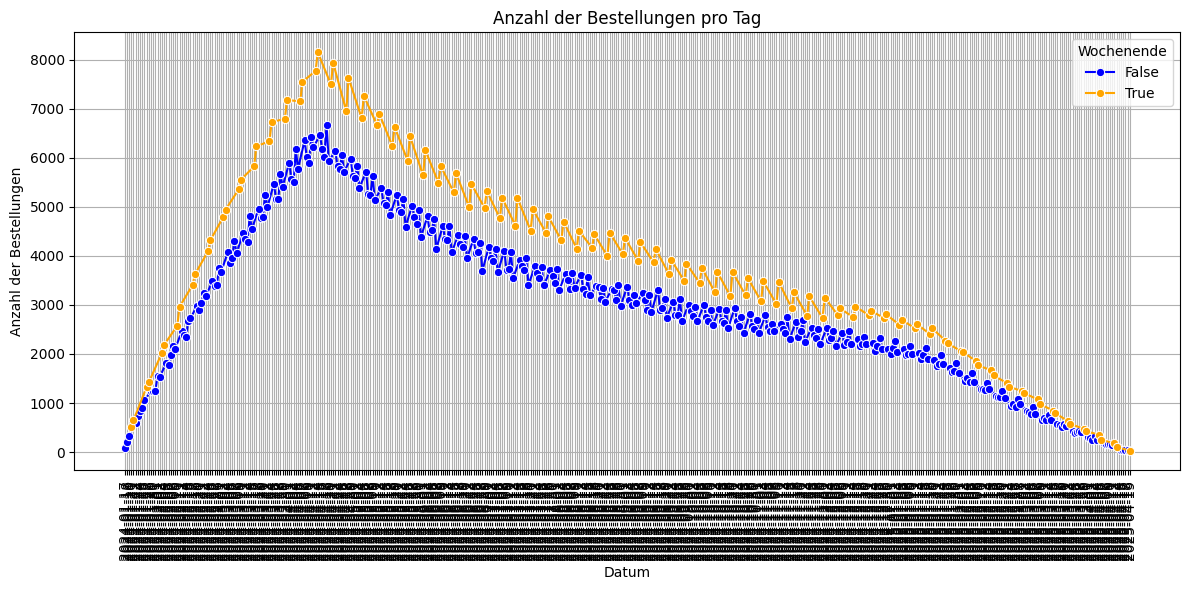

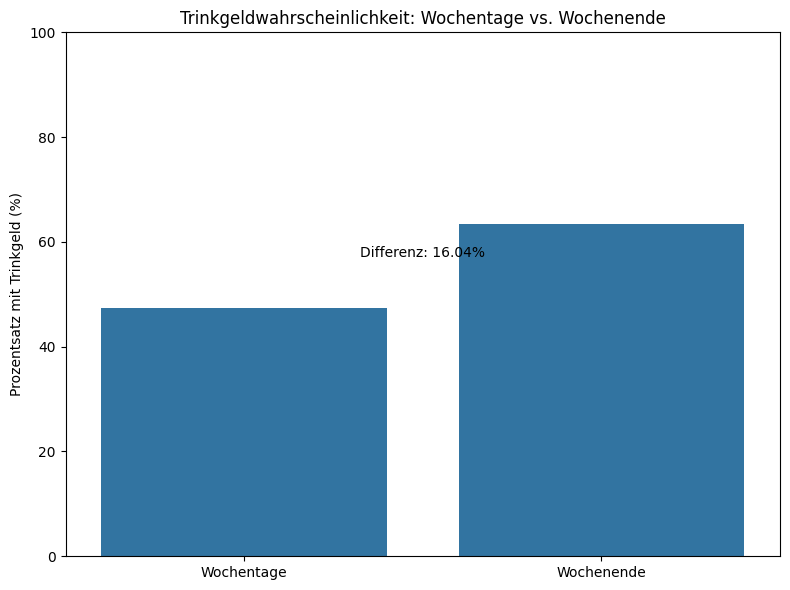

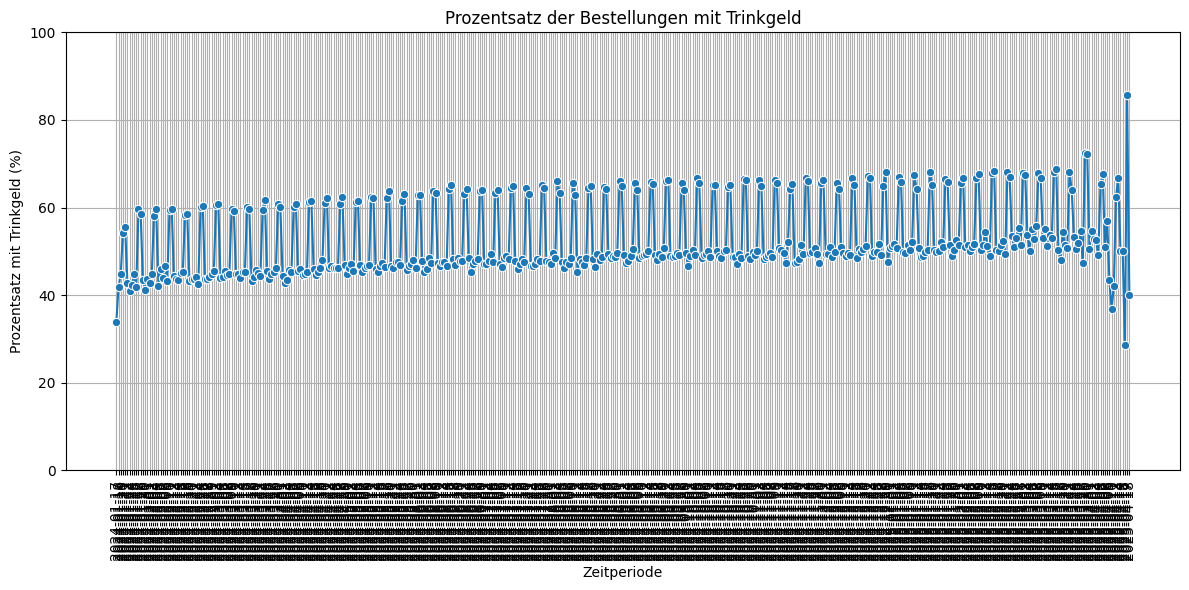

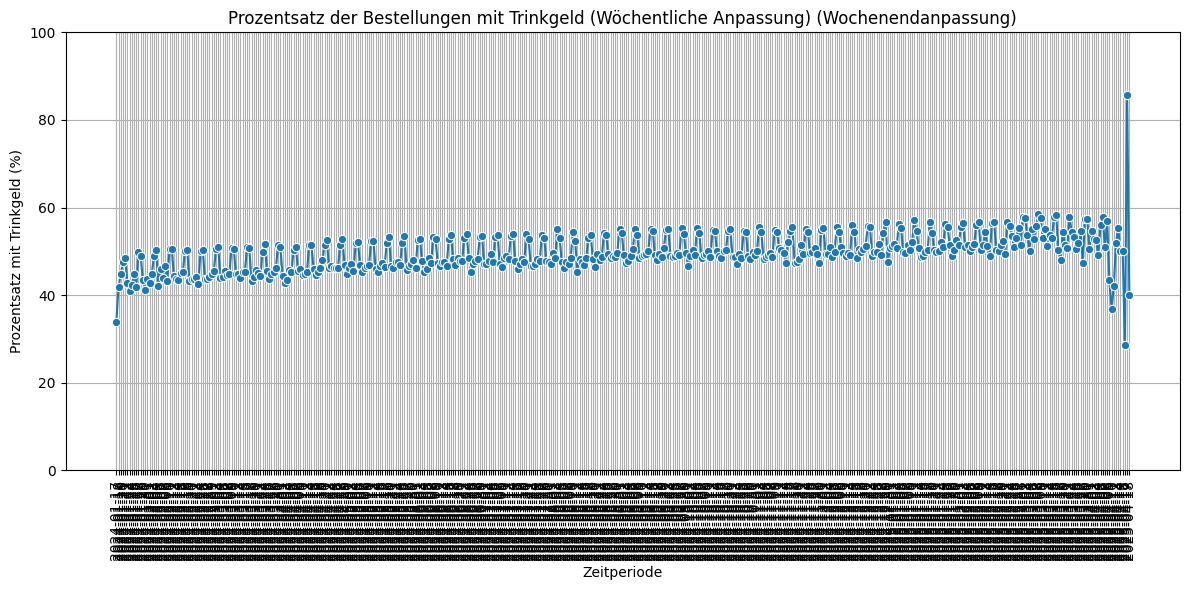

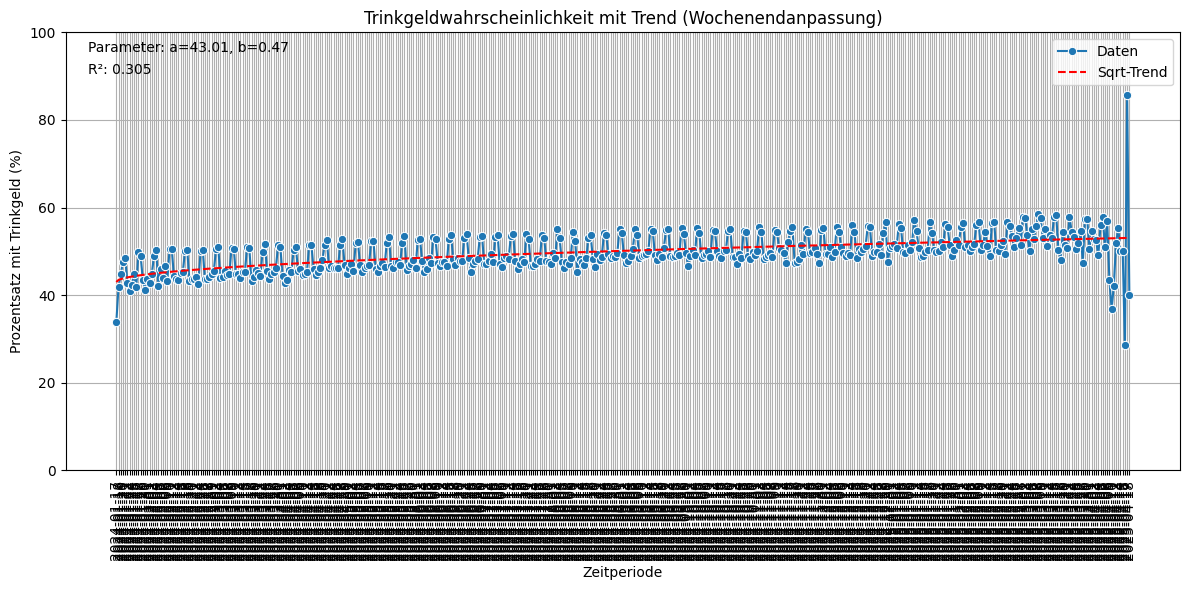

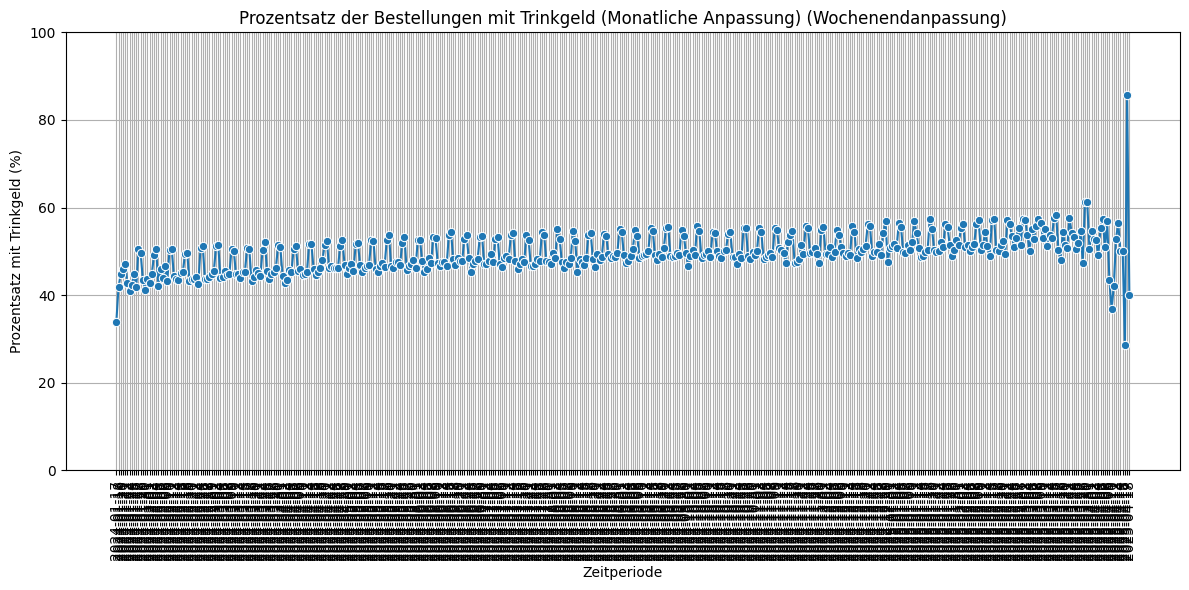

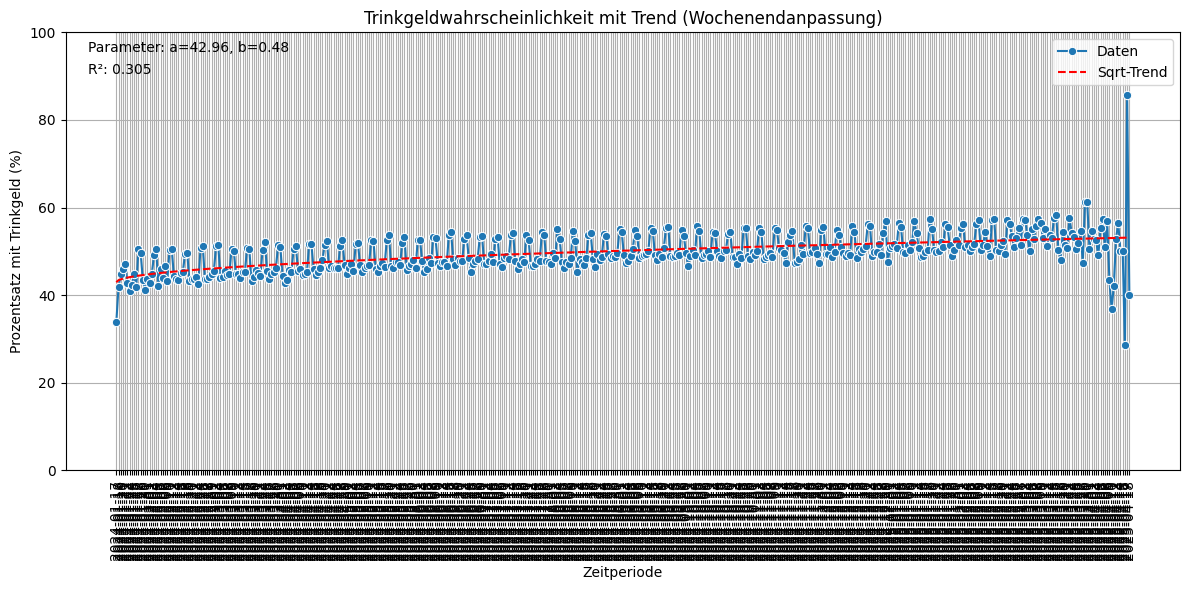

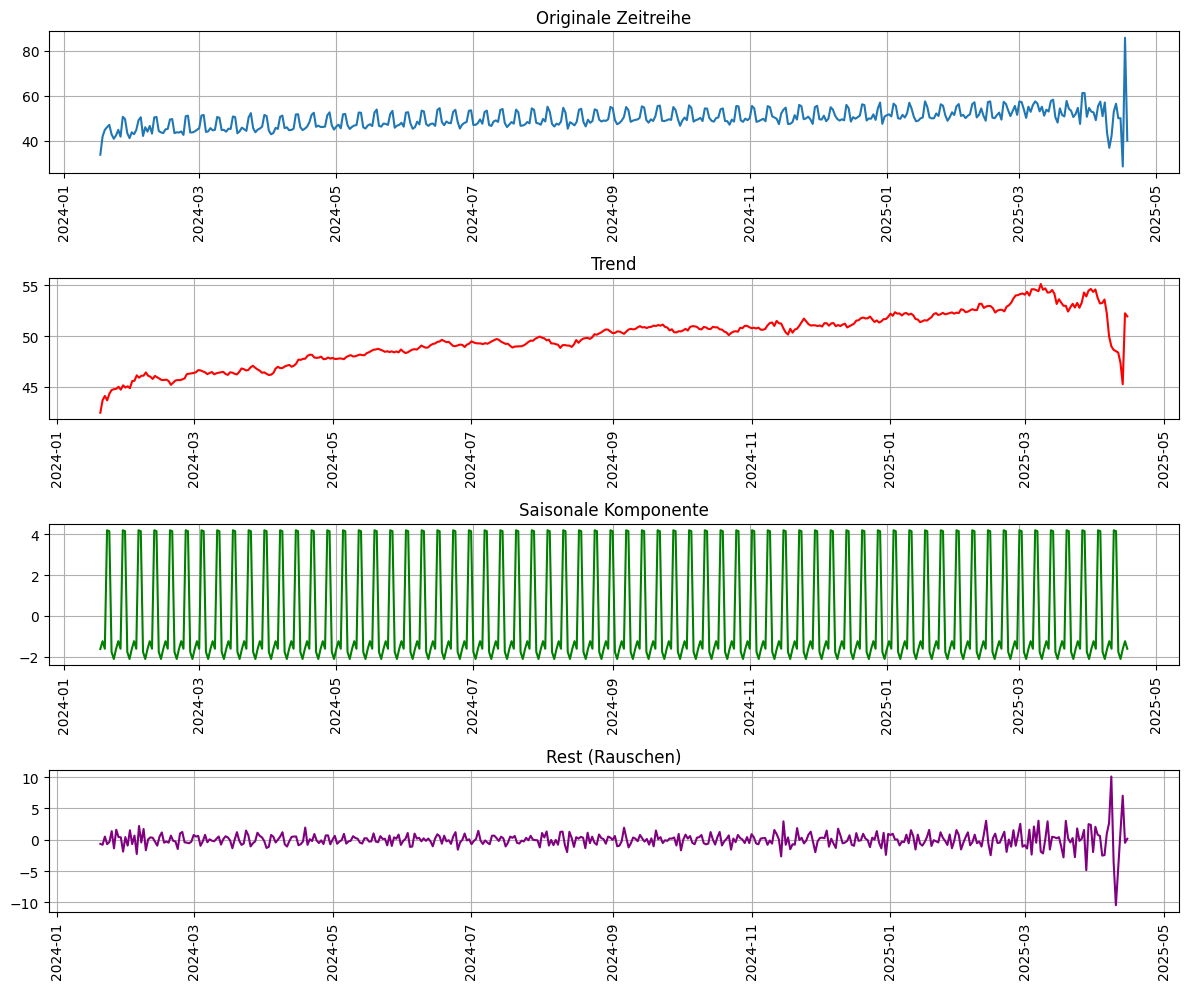

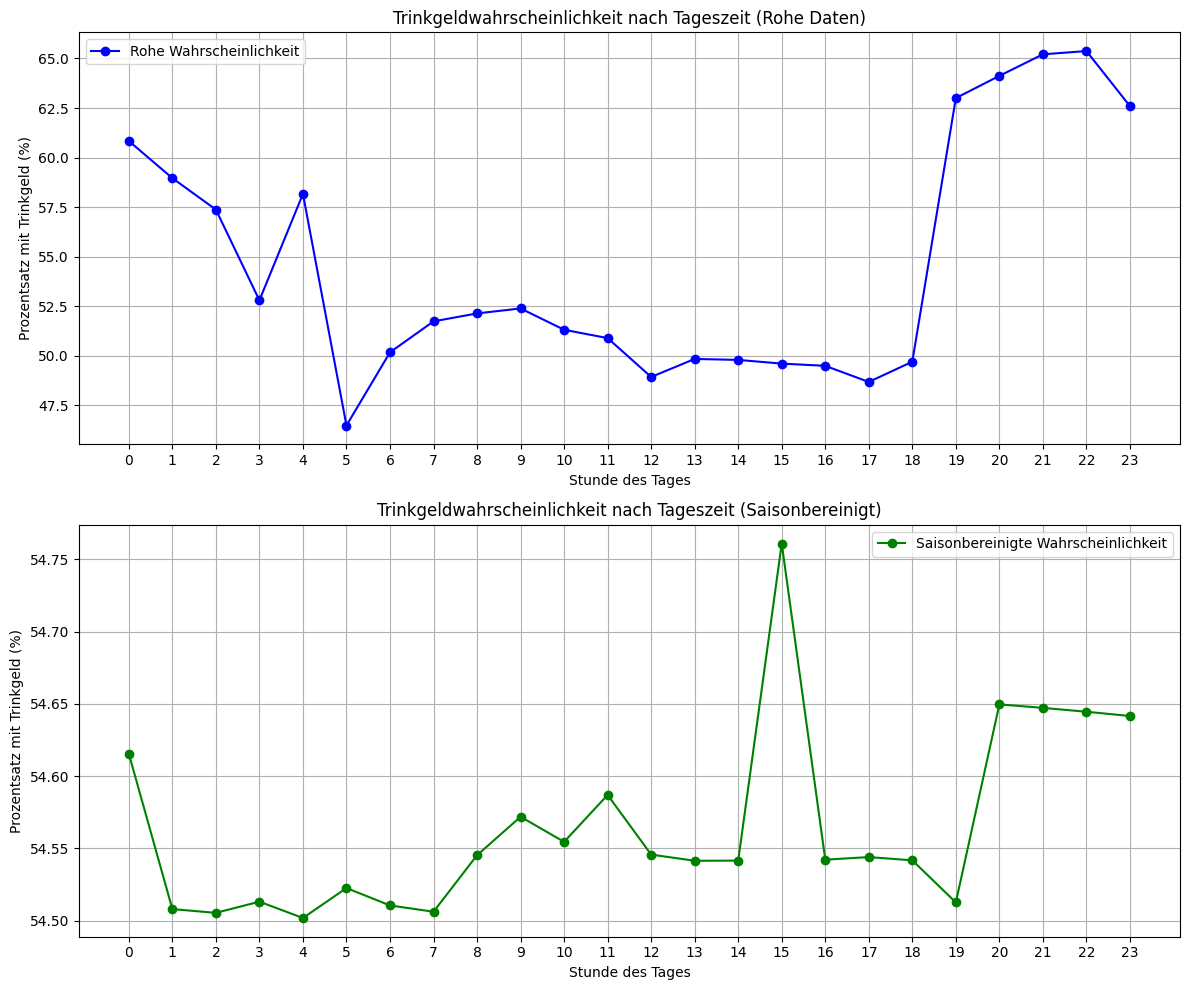

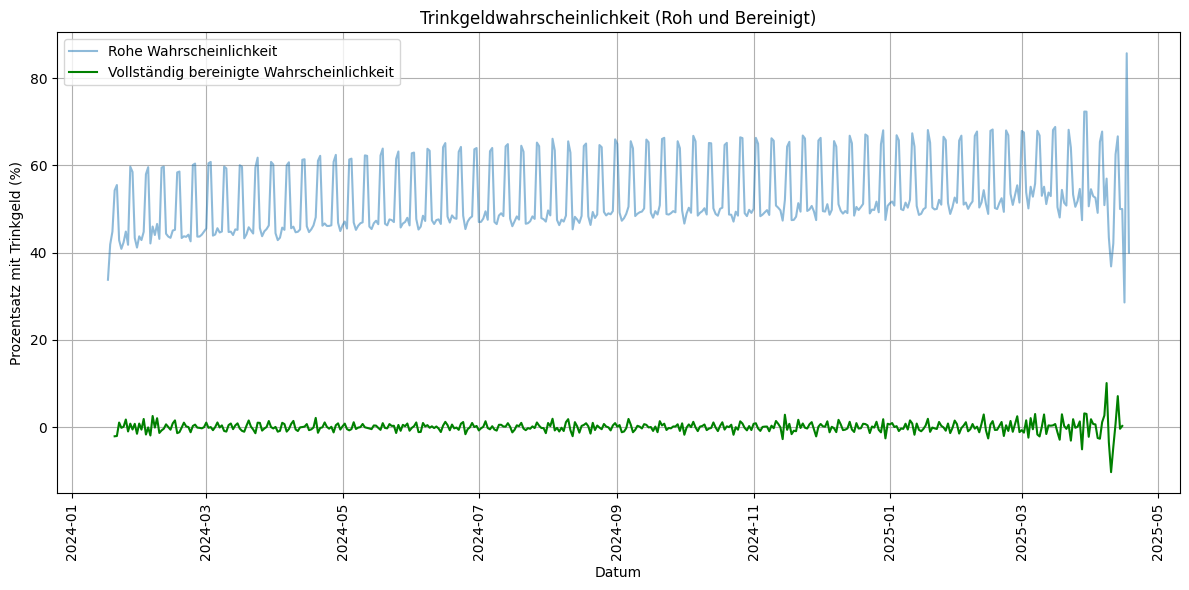

Genauigkeit auf Testdaten:
Accuracy: 0.48
Precision: 0.29
Recall: 0.05
F1-Score: 0.08


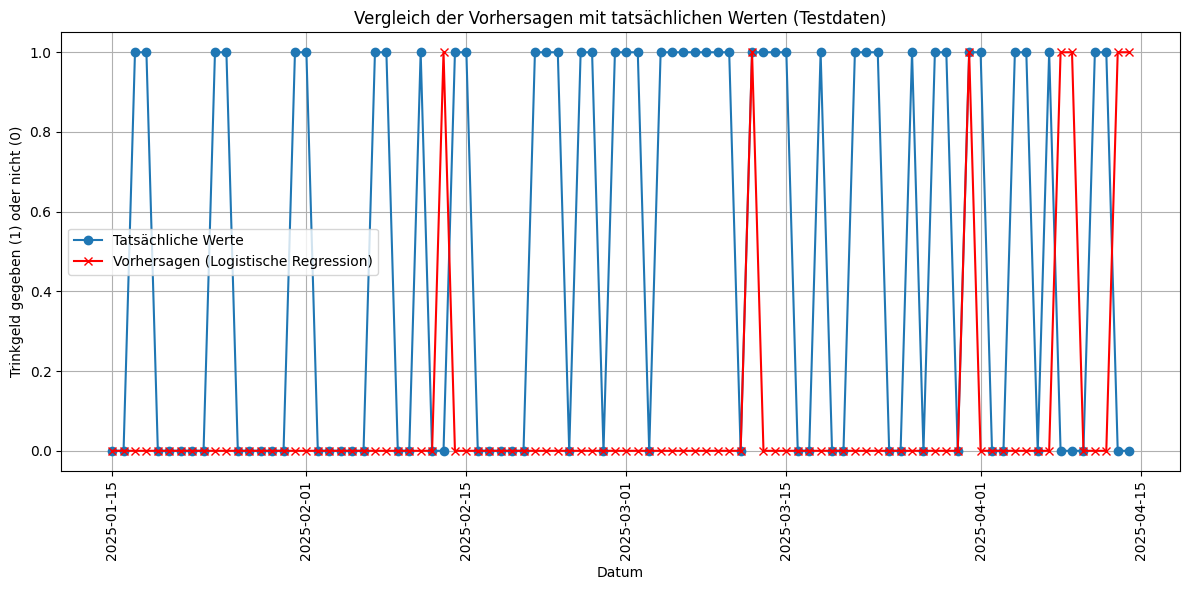

In [50]:
def main3():
    # Filter days with less than X orders (e.g., X = 10)
    min_orders = 10
    filtered_orders = filter_low_order_days(orders, min_orders=min_orders)
    
    # Bestehende Analysen
    ##plot_daily_order_counts(filtered_orders)
    tip_percentage = create_daily_tip_probability(filtered_orders, tips_public, period='D')
    weekday_tip_rate, weekend_tip_rate, tip_diff = calculate_weekend_weekday_diff(filtered_orders, tips_public)
    ##plot_weekend_weekday_diff(weekday_tip_rate, weekend_tip_rate, tip_diff)
    ##plot_tip_time_series(tip_percentage, 'Prozentsatz der Bestellungen mit Trinkgeld', adjusted=False)
    
    # Wöchentliche Anpassung
    tip_percentage_adjusted = create_adjusted_daily_tip_probability(filtered_orders, tips_public, period='D')
    ##plot_tip_time_series(tip_percentage_adjusted, 'Prozentsatz der Bestellungen mit Trinkgeld (Wöchentliche Anpassung)', adjusted=True)
    y_pred, r_squared, popt = fit_trend_curve(tip_percentage_adjusted, trend_type='sqrt')
    ##plot_trend_curve(tip_percentage_adjusted, y_pred, r_squared, popt, trend_type='sqrt')
    
    # Monatliche Anpassung
    tip_percentage_adjusted_monthly = create_adjusted_daily_tip_probability_monthly(filtered_orders, tips_public, period='D')
    ##plot_tip_time_series(tip_percentage_adjusted_monthly, 'Prozentsatz der Bestellungen mit Trinkgeld (Monatliche Anpassung)', adjusted=True)
    y_pred_monthly, r_squared_monthly, popt_monthly = fit_trend_curve(tip_percentage_adjusted_monthly, trend_type='sqrt')
    ##plot_trend_curve(tip_percentage_adjusted_monthly, y_pred_monthly, r_squared_monthly, popt_monthly, trend_type='sqrt')
    
    # Saisonale Dekomposition
    decompose_tip_time_series(tip_percentage_adjusted_monthly, period=7)
    
    # Trinkgeldwahrscheinlichkeit nach Tageszeit
    plot_tip_probability_by_hour(filtered_orders, tips_public)
    
    # Neue Analyse: Saisonale Bereinigung, Lag-Features, Vorhersage und Genauigkeitstest
    remove_seasonality_and_trend_predict_with_lags(filtered_orders, tips_public, n_lags=3, train_split=0.8)

main3()